## Reading in the dataset

In [138]:
import os, sys
import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import operator
import matplotlib.pyplot as plt
%matplotlib inline
plot = False

assert os.path.exists('./emails.train.csv'), "[Dataset File Not Found] Please download dataset first."

## Text cleaning

In [128]:
import nltk

def text_regularize(dataframe, method='lemm'):
    print('Performing: %s ...' % method)
    def stemming(worker, tag):
        return worker.stem(tag)

    def lemmatize(worker, tag):
        return worker.lemmatize(tag)

    if   method=='stem':
        worker = nltk.PorterStemmer()
        func = stemming
    elif method=='lemm':
        worker = nltk.WordNetLemmatizer()
        func = lemmatize
    else:
        raise NotImplementedError

    for i, line in enumerate(dataframe['text']):
#         haalt de woorden uit de dataframe
        elems = line.strip().split()
    
        # apply stemming or lemmatize
        newtags = [func(worker,tag.lower()) for tag in elems]
        newline = " ".join(newtags)

        # update text
        dataframe.loc[i,'text'] = newline

    # return dataframe

In [129]:
def cleaning_text(dataframe):
    print('Cleaning text...')
    import re
    
    for i, line in enumerate(dataframe['text']):
        
        # remove special characters using regex
        line = re.sub(r'[^\w]', ' ', line).lower()
        # remove numeric characters using regex
        line = re.sub("(^|\W)\d+($|\W)", " ", line)
           
        # remove words of two characters or less
        words = line.split()
        resultwords = []
        
        for word in words:
            word = word.lower()
            if len(word) > 2:
                resultwords.append(word)
                
        newline = ' '.join(resultwords)

        dataframe.loc[i, 'text'] = newline

    return dataframe
        
print('========= Clean training data ==========')
# Read in training data
df = pd.read_csv('./emails.train.csv')

# Do cleaning
cleaning_text(df)
text_regularize(df, 'lemm')
text_regularize(df, 'stem')

# Save as new file
df.to_csv('emails_clean.train.csv')

print('========= Clean testing data ==========')
# Read in testing data
df = pd.read_csv('./emails.test.csv')

# Do cleaning
df = cleaning_text(df)
text_regularize(df, 'lemm')
text_regularize(df, 'stem')

# Save as new file
df.to_csv('emails_clean.test.csv')

print('Cleaned the data')

========= Clean training data ==========
Cleaning text...
Performing: lemm ...
Performing: stem ...
========= Clean testing data ==========
Cleaning text...
Performing: lemm ...
Performing: stem ...
Cleaned the data


## Retrieve word frequency

In [130]:

# get word frequency data for both train data
def word_frequency_train(dataframe):
    # for w in dataframe.str.lower():
#     create a dataframe of all words
    
    datasetwords = {}
    
    for line in dataframe["text"]:
        words = line.split()
        for word in words:
            if word in datasetwords:
                datasetwords[word] += 1
            else:
                datasetwords[word] = 1
    
    return datasetwords

# get word frequency data for mails
def word_frequency_mail(mail):
    words = mail.split()
    datasetwords = {}
    for word in words:
        if word in datasetwords:
            datasetwords[word] += 1
        else:
            datasetwords[word] = 1
    
    return datasetwords

    

# Naive Bayesian

In [131]:
# freqsword = frequency word in spam, freqhword is frequency word in ham
def NaiveBayesian(probspam,freqsword,freqhword,totalfreqs,totalfreqh):
    
#   probability of a mail being ham 
    probham = 1-probspam
    
#   calculate probability of word being in spam or word being in spam
    probwordspam = float(freqsword)/(totalfreqs)
    probwordham = float(freqhword)/(totalfreqh)
    bayes = (float(probwordspam*probspam)/(probwordspam*probspam + probwordham*probham))


#       equation for correcting the probability where s =3 means that meaning that the learned dictionary
#       must contain more than 3 messages with the word
    s = 3
    correctedbayes = float(s*probspam+freqsword*bayes)/(s+freqsword)
    
#   if the spamicity of the word is around 0.5 return none since the probability of the word being ham or spam
#   is too similar so we evaluate only spammicities of <=0.2 and >= 0.8
    
    if correctedbayes >= 0.8 or bayes <=0.2:
        return correctedbayes

    else:
        return None


In [132]:

# Here we call our Naive Bayesian performer with the data we read in from train and test and check
# if the test mail is spam or not
def CallBae(freqspam,freqham,mail,probspam,totalfreqs,totalfreqh):
    spamchecklist = []
    
    for word in mail:
    
#     if word in spam and ham check its frequency and perform the Bayesian as many times as needed
        if word in freqspam and word in freqham:
            for i in range(mail[word]):
                freqsword = freqspam[word]
                freqhword = freqham[word]
                spamchecklist.append(NaiveBayesian(probspam,freqsword,freqhword,totalfreqs,totalfreqh))

    #   if the word is in neither spam or ham we continue the word iteration
        elif word not in freqspam and word not in freqham:
            continue

    #  we initialize freqsword as a tiny number here cause else the Bayesian would not be able to pick up that 
    #  the word is in ham if the word never appears in spam but does appear in ham
        elif word in freqham and word not in freqspam:
            for i in range(mail[word]):
                freqsword = 10**(-8)
                freqhword = freqham[word]
                spamchecklist.append(NaiveBayesian(probspam,freqsword,freqhword,totalfreqs,totalfreqh))

            
#   Clean up the spamchecklist
    spamchecklist = np.array(spamchecklist)
    spamchecklist = spamchecklist[spamchecklist != np.array(None)]
       
#   Count all probabilities in spamchecklist and calculate the overal probability of the mail being spam or ham
    multiplicationsum = np.prod(spamchecklist)
    ones = np.ones(spamchecklist.shape)
    pminusonesum = np.prod(ones-spamchecklist)
    
#   Make sure we won't have conflicts with machine precision for if the mail is almost certainly spam we get very
#   small numbers which add to 0 under machine precision
    if pminusonesum + multiplicationsum ==0:
        finaljudge = 1
    else:   
        finaljudge = multiplicationsum/(multiplicationsum+pminusonesum)
            
#   Return False if spam
    if finaljudge > 0.5:
        return True
#   Return True if ham
    if finaljudge < 0.5:
        return False

In [133]:
# Takes as input frequency table of spam words, frequency table of ham words,the mail we have to check,
# probability mail is spam, total frequency of words in spam and total frequency of words  in  ham
def Classifier(freqspam,freqham,test,probspam,totalfreqs,totalfreqh,train):
    iddict = {}
    spamdict = {}
    idlist = []
    spamlist = [] 
    
# loop through all the mails in the test and perform naive bayesian and add id number to the list
    for i in range(len(test)):
        idlist.append(test['id'][i])
        mail = test['text'][i]        
        mail = word_frequency_mail(mail)
    
#         if we get True from CallBae mail is spam and we add it to the spam dictionary
        if CallBae(freqspam,freqham,mail,probspam,totalfreqs,totalfreqh):
            spamlist.append(1)

            freqspam = combine_dicts(freqspam,mail)
            totalfreqs = sum(freqspam.values())      
    
#             If we get False from Callbae mail is added to ham dictionary and defined as ham
        else:
            spamlist.append(0)
            freqham = combine_dicts(freqham,mail)
            totalfreqh = sum(freqham.values())
                   
    
#   create our submission with per id the indicator whether the mail is spam or not (1 or 0)
    spamdict['spam'] = spamlist
    iddict['id'] = idlist
    spamdict = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in spamdict.items()]))
    iddict = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in iddict.items()]))
    submission = pd.concat([iddict,spamdict],axis = 1)
    submission.set_index('id',inplace=True)
#   if we are not plotting save the submission file
    if not plot:
        submission.to_csv('submission.csv')
    return submission,idlist



In [134]:
# function for combining dictionaries
def combine_dicts(a, b, op=operator.add):
    return dict(a.items() + b.items() +[(k, op(a[k], b[k])) for k in set(b) & set(a)])

In [139]:
# intialize initials
train = pd.read_csv('./emails_clean.train.csv')
test  = pd.read_csv('./emails_clean.test.csv')
hamdata = train[train.spam == 0]
spamdata = train[train.spam == 1]
# here we make our word dictionaries
freqham = word_frequency_train(hamdata)
freqspam = word_frequency_train(spamdata)
totalfreqs = sum(freqspam.values())
totalfreqh = sum(freqham.values())

# CALL FUNCTIONS AND EVALUATE USING MEAN CONSEQUENTIAL EVALUATER

# if we are plotting save the results as a list
if plot:
    MCE = []
    for j in np.arange(0.05,1,0.05):
        probspam = j
        submission,idlist = Classifier(freqspam,freqham,test,probspam,totalfreqs,totalfreqh,train)
        ms = 0

        for i in idlist:
            try:      
                if test.loc[test['id'] == i, 'spam'].iloc[0] != submission["spam"][i]:
                    ms +=1
            except:
                continue

        MCE.append(1./submission.shape[0]*ms)

#  if we  are not plotting print out the result
else:
    probspam = 0.5
    submission,idlist = Classifier(freqspam,freqham,test,probspam,totalfreqs,totalfreqh,train)
    ms = 0
    for i in idlist:
        try:      
            if test.loc[test['id'] == i, 'spam'].iloc[0] != submission["spam"][i]:
                ms +=1
        except:
            continue

    MCEbay = (1./submission.shape[0]*ms)

    print "The Naive Bayesian has a ratio of: %0.3f" %(1-MCEbay) + " correct mails"

## Plotting

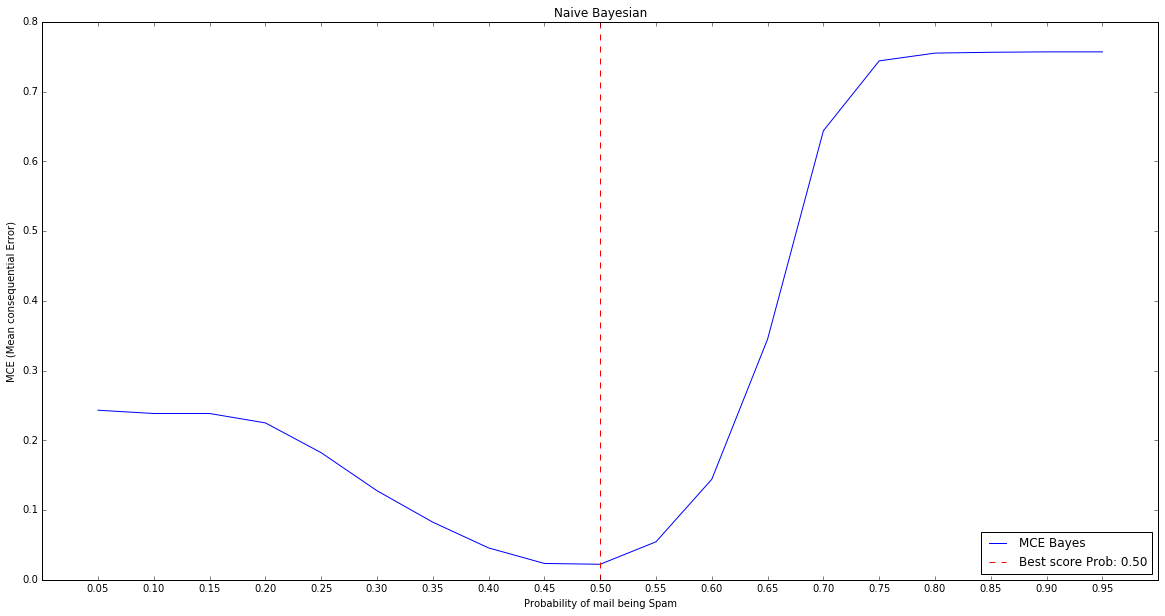

In [140]:
#  Plot the figure
if plot:
    plt.figure(figsize=(20,10))
    x = np.arange(0.05,1,0.05)
    plt.plot(x,MCE, label = "MCE Bayes")
    plt.title("Naive Bayesian")
    plt.ylabel("MCE (Mean consequential Error)")
    plt.xlabel("Probability of mail being Spam")
    plt.axvline(x[np.argmin(MCE)], linestyle='--',color="r",label="Best score Prob: %0.2f" %x[np.argmin(MCE)])
    plt.xticks(x)

    plt.legend(loc='lower right')
    plt.savefig("NB")
    plt.show()


# SVM method

In [22]:
# Read in csv file as dataframe
df = pd.read_csv('./emails_clean.train.csv')

In [23]:
def select_vocabulary(dataframe):
    # for w in dataframe.str.lower():
    word2freq = dict()
    for line in dataframe:
        words = line.split()
#       met setdefault fixed ie de value in de dict op 0 tenzij er iets te tellen valt dan +1
        for word in words:
            word2freq[word] = word2freq.setdefault(word, 0) +1

    word_freq = [ (word,freq) for word,freq in word2freq.items() ]
    
    # sort according to freq, in descending order.
    word_freq.sort(key=lambda x:x[1], reverse=True) 
    
#     returned top all words
    return([x[0] for x in word_freq[:]])

vocabulary = select_vocabulary(df['text'])
word2ind   = dict(zip(vocabulary, range(len(vocabulary))))


In [24]:

# Extract bag of words as a word vector
def extract_Bag_of_Word_feature(dataframe):
    BoWs = np.zeros((len(dataframe), len(vocabulary)), dtype=np.float32)

    for i, line in enumerate(dataframe):
        for word in line.split():
            word_ind = word2ind.get(word, -1)
            if(word_ind>=0):
                BoWs[i, word_ind] += 1

            
    return BoWs


# Use cleaned data
train = pd.read_csv('./emails_clean.train.csv')
test  = pd.read_csv('./emails_clean.test.csv')

# Get labels
Y_train = train['spam']
Y_test  = test['spam']


In [25]:
# use sklean SVM method (Support Vector Machine)

from sklearn.metrics import average_precision_score, accuracy_score
from sklearn.svm import SVC

model = SVC()

model.fit(X_train, Y_train)

def eval(model, X_test, Y_test, method=''):
    
    # Predict decision labels.
    Y_pred  = model.predict(X_test)  

    # Predict confidence scores.
    Y_score = model.decision_function(X_test)    

    # write to submit format
    outf = 'kaggle_data/solution.%s.csv'% method
    with open( outf, 'w') as f:
        f.write('id,spam\n')
        for i in range(len(Y_pred)):
            # print test['id'][0]
            f.write('%s,%s\n' % (test['id'][i], Y_pred[i]) )
    
# evaluate current model
eval(model, X_test, Y_test, method='SVM')

In [115]:
# use MCE to evaluate output of SVM
ms = 0
svm = pd.read_csv('kaggle_data/solution.SVM.csv')
for i in range(len(test)):
    try:      
        if test.loc[test['id'] == i, 'spam'].iloc[0] != svm.loc[svm['id'] == i, 'spam'].iloc[0]:
            ms +=1
    except:
        continue

MCEsvm = (1./submission.shape[0]*ms)


# Comparison

In [116]:
if not plot:
    print "The Support Vector Machine method has a ratio of %0.3f" %(1 - MCEsvm) +" spam mails correct"
    print "The Naive Bayesian has a ratio of %0.3f" %(1 - MCEbay) + " spam mails correct"
else:
    print "Please first put the Naive Bayesian on plot == False"

The Support Vector Machine method has a ratio of 0.864 spam mails correct
The Naive Bayesian has a ratio of 0.978 spam mails correct
